In [1]:
# change cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import scipy as sp
from scipy.integrate import odeint
import scipy
import jax

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
from functools import partial,reduce
from jax import jacfwd, jacrev,jvp
import jax


def radial_hyperbolic_compactification(x):
    """ y = (x/|x|) atan(|x|) 2/π. Sends |x|=-∞ to |y|=-1 and |x|=∞ to |y|=1."""
    r2 = jnp.maximum((x**2).sum(),1e-12)#jnp.maximum(jnp.linalg.norm(x),1e-6)
    rbar = (jnp.arctan(jnp.sqrt(r2))*2/jnp.pi)
    taylor = (2/jnp.pi)*(1 - r2/3+r2**2/5-r2**3/7+r2**4/9)
    return x*jnp.where(r2>1e-3,rbar/jnp.sqrt(r2),taylor)

def inv_radial_hyperbolic_compactification(y):
    """ x = (y/|y|) tan(|y| π/2) Sends |y|=-∞ to |x|=-1. and |y|=1 to |x|=∞"""
    rbar = jnp.maximum(jnp.sqrt((y**2).sum()),1e-12)#jnp.maximum(jnp.linalg.norm(y),1e-6)
    r = jnp.tan(((rbar))*jnp.pi/2)
    return y*r/rbar

def square_compactification(x):
    return jnp.arctan(x)*2/jnp.pi

def inv_square_compactification(y):
    return jnp.tan(y*jnp.pi/2)

In [104]:
# define the hydrogen atom Hamiltonian transformed coordinates
N=2000
ndims = 1

from jax.config import config
import scipy
config.update("jax_enable_x64", True)
#grid = jnp.linspace(0+.0001,1-.0001,N) # convert to 3d with mesgrid

#grid = jnp.linspace(-1,1,N)
grid = jnp.linspace(-40,40,N)
print(grid.dtype)
wgrid = jnp.stack(jnp.meshgrid(*(ndims*[grid])),axis=-1).reshape(-1,ndims)
idd = lambda x:x


T = idd#square_compactification#idd#lambda x: jax.scipy.stats.norm.cdf(norm(x)/3)*x/norm(x)#jnp.log(1e-1+norm(x))*x/norm(x)#radial_hyperbolic_compactification
Tinv = idd#inv_square_compactification#idd#lambda x: 3*jax.scipy.special.ndtri(norm(x))*x/norm(x)#(jnp.exp(norm(x))-1e-1)*x/norm(x)#inv_radial_hyperbolic_compactification
xyz = vmap(Tinv)(wgrid)
print(xyz[0],xyz[-1])
DT = vmap(jacfwd(T))(xyz) # (b, 3-out, 3-in)
laplacian_factor2 = DT@DT.transpose((0,2,1))
laplacian_factor1 = vmap(lambda z: (jacfwd(jacfwd(T))(z)*jnp.eye(ndims)[None,:,:]).sum((1,2)))(xyz)
dw = grid[1]-grid[0]
deriv = jnp.array([-1/2,0.,1/2])/dw
#deriv = jnp.array([-1.,1.])/dw
#di = lambda x,i: sp.ndimage.correlate1d(x,deriv,axis=i,mode='constant')
def hdiag(x):
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dw**2,mode='same')
    dds = jnp.stack([jnp.apply_along_axis(cderiv,i,x).reshape(-1) for i in range(ndims)],axis=0)
    embedded_diag = vmap(jnp.diag,-1,-1)(dds).transpose((2,0,1))
    print(embedded_diag.shape)
    return embedded_diag
    
jderiv = lambda x: jax.scipy.signal.correlate(x,deriv,mode='same') #BCS?
di = lambda x,i: jnp.apply_along_axis(jderiv,i,x)
d = lambda x,axis=-1: jnp.stack([di(x,i) for i in range(ndims)],axis=axis)
# lap= lambda x: scipy.ndimage.laplace(x,mode='constant')/dw**2
def lap(x):
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dw**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x).reshape(-1) for i in range(ndims)])

from jax.config import config
config.update("jax_enable_x64", True)
def vfn(x):
    return (x*x).sum()/2

# def vfn(x):
#     return (x*x).sum()/2

@jit
def laplacian(psi):
    psi_grid = psi.reshape(*(ndims*(N,)))
#     return lap(psi_grid).reshape(psi.shape)
    #return out
    
    #return (hessian*jnp.eye(ndims)[None]).sum((1,2)).reshape(psi.shape)
    dpsi = d(psi_grid)
    hessian = d(dpsi).reshape(-1,ndims,ndims)
    hessian = jnp.where(jnp.eye(ndims)[None]+0*hessian>0.5,hdiag(psi_grid),hessian)
    l1 = (dpsi.reshape(-1,ndims)*laplacian_factor1).sum(-1)
    l2 = (hessian*laplacian_factor2).sum((1,2))
    return (l1+l2).reshape(psi.shape)

@jit
def H(psi):
    KE = -laplacian(psi)/2
    V = psi*vmap(vfn)(xyz).reshape(psi.shape)
    return KE+V

def Hnp(psi):
    return np.asarray(H(psi))

float64
[-40.] [40.]


In [105]:
x = jnp.array([-1,2,3,5])
x = jax.scipy.signal.convolve(x,jnp.array([-1,1]),mode='same')
x = jax.scipy.signal.convolve(x,jnp.array([-1,1]),mode='same')
print(x)
print(jax.scipy.signal.correlate(jnp.array([-1,2,3,5]),jnp.array([1,-2,1]),mode='same'))

[-1.  4. -2.  1.]
[ 4. -2.  1. -7.]


In [106]:
f = lambda x: jnp.array([1,2,3,4])*.1

jacfwd(f)(jnp.zeros(10)).shape

(4, 10)

In [107]:
from scipy.sparse.linalg import LinearOperator, eigsh
matmat = vmap(H,-1,-1)

Hop = LinearOperator(2*(wgrid.shape[0],),matvec = H,rmatvec = H,matmat=matmat,rmatmat=matmat,dtype=np.float32)

In [108]:
Hop@jnp.ones((Hop.shape[0],2))

(2000, 1, 1)


DeviceArray([[1112.18757813, 1112.18757813],
             [ 798.4000004 ,  798.4000004 ],
             [ 796.8016024 ,  796.8016024 ],
             ...,
             [ 796.8016024 ,  796.8016024 ],
             [ 798.4000004 ,  798.4000004 ],
             [1112.18757813, 1112.18757813]], dtype=float64)

In [109]:
xyz.shape

(2000, 1)

In [110]:
def psi0(x):
    return jnp.exp(-(x**2).sum()/2)
def psi1(x):
    return jnp.prod(x)*jnp.exp(-(x**2).sum()/2)
psi0_t = vmap(psi0)(xyz)
psi1_t = vmap(psi1)(xyz)

In [111]:
(psi0_t@(Hop@psi0_t))/(psi0_t@psi0_t)

(2000, 1, 1)


DeviceArray(0.49994996, dtype=float64)

In [112]:
(psi1_t@(Hop@psi1_t))/(psi1_t@psi1_t)

DeviceArray(1.4997498, dtype=float64)

In [116]:
s = (Hop@psi1_t)/(psi1_t+1e-4)
print(s[s>1e-3].mean())

1.453798604047178


In [117]:
hh = Hop@np.eye(Hop.shape[0])
e,v = np.linalg.eig(hh)
order = np.argsort(e)
e=e[order]
v=v[:,order]
k=20

In [115]:
k=6
e,v = eigsh(Hop,which='BE',k=k,tol=1e-4)
e = e[:k//2]
v = v[:,:k//2]

(2000, 1, 1)


In [118]:
e[:50]

array([ 0.49994994,  1.4997497 ,  2.49934917,  3.49874829,  4.497947  ,
        5.49694524,  6.49574294,  7.49434005,  8.49273651,  9.49093226,
       10.48892723, 11.48672137, 12.48431461, 13.4817069 , 14.47889817,
       15.47588836, 16.47267741, 17.46926526, 18.46565185, 19.46183711,
       20.45782099, 21.45360343, 22.44918436, 23.44456372, 24.43974145,
       25.43471749, 26.42949178, 27.42406425, 28.41843485, 29.4126035 ,
       30.40657016, 31.40033476, 32.39389723, 33.38725751, 34.38041554,
       35.37337127, 36.36612462, 37.35867554, 38.35102395, 39.34316981,
       40.33511305, 41.3268536 , 42.3183914 , 43.30972639, 44.3008585 ,
       45.29178768, 46.28251386, 47.27303698, 48.26335697, 49.25347378])

In [103]:
e[:50]

array([ 0.49999978,  1.49999796,  2.49999308,  3.49998246,  4.49996275,
        5.49992961,  6.49987779,  7.49980112,  8.49969248,  9.49954386,
       10.49934629, 11.49908989, 12.49876384, 13.49835638, 14.49785485,
       15.49724563, 16.49651417, 17.495645  , 18.49462168, 19.49342686,
       20.49204222, 21.49044853, 22.48862558, 23.4865522 , 24.4842063 ,
       25.4815648 , 26.47860366, 27.47529786, 28.47162144, 29.46754741,
       30.46304782, 31.45809372, 32.45265516, 33.44670116, 34.44019974,
       35.43311789, 36.42542155, 37.41707562, 38.40804393, 39.39828924,
       40.38777324, 41.37645651, 42.36429849, 43.35125754, 44.33729084,
       45.32235441, 46.3064031 , 47.28939055, 48.27126918, 49.25199017])

In [23]:
e

array([0.9897604, 1.9688346, 1.9689178, 2.9264765, 2.9265738, 2.9478898,
       3.8620524, 3.8621988, 3.9056623, 3.9058406, 4.7744446, 4.7744718,
       4.84118  , 4.8413863, 4.8634853], dtype=float32)

In [24]:
.5/25

0.02

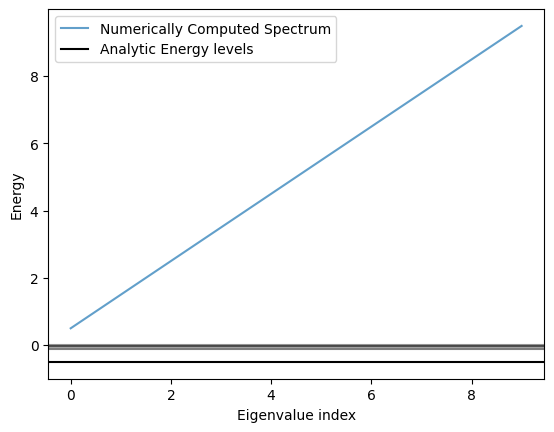

In [119]:
import matplotlib.pyplot as plt
j = np.arange(k//2)
plt.plot(j,e[:k//2],alpha=.7,label=r"E_n")
for i in j:
    plt.axhline(-0.5/(1+i)**2,color='k',alpha=1/(1+i))
plt.xlabel('Eigenvalue index')
plt.ylabel('Energy')
plt.legend(['Numerically Computed Spectrum','Analytic Energy levels'])
#plt.plot(j,-1/j**2,label=r"$-1/n^2$")

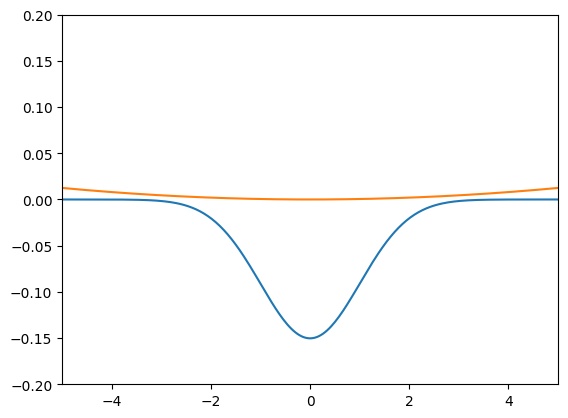

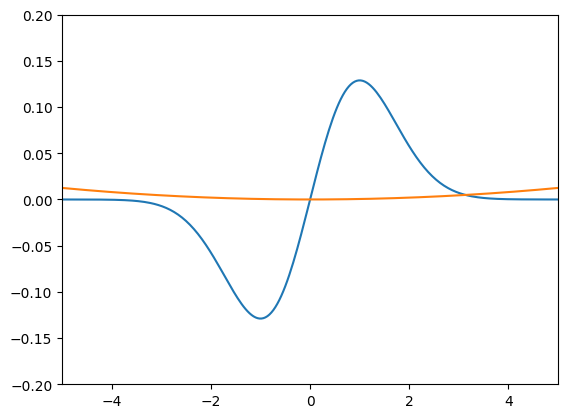

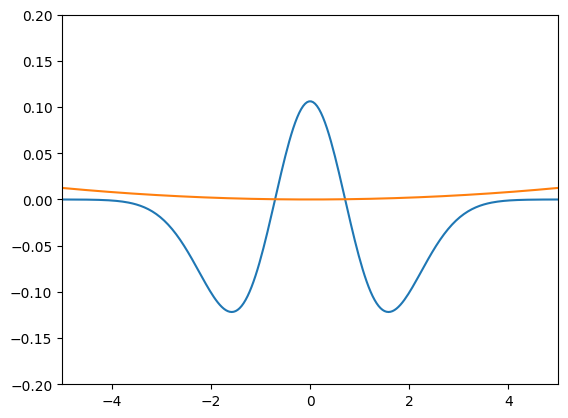

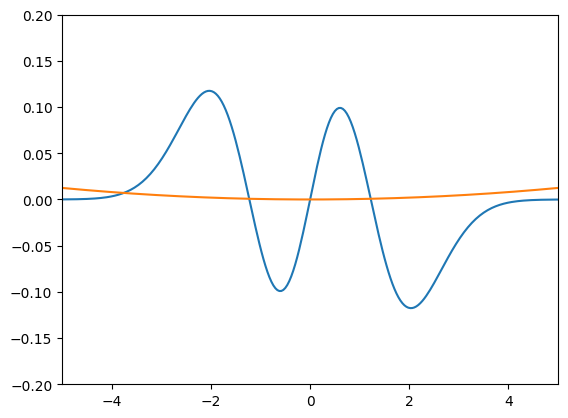

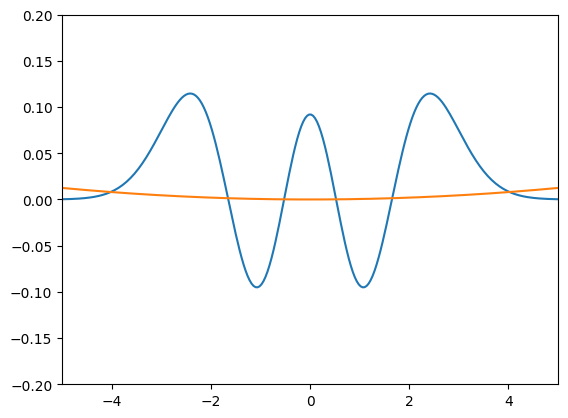

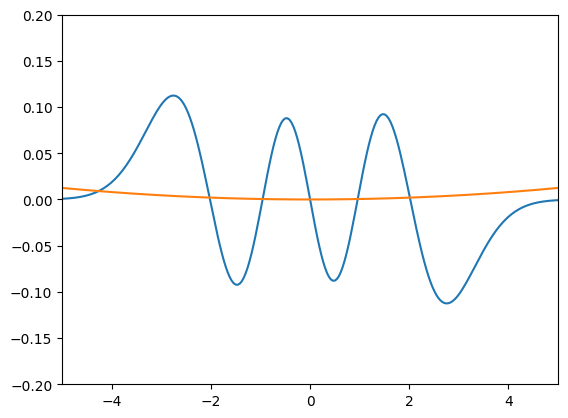

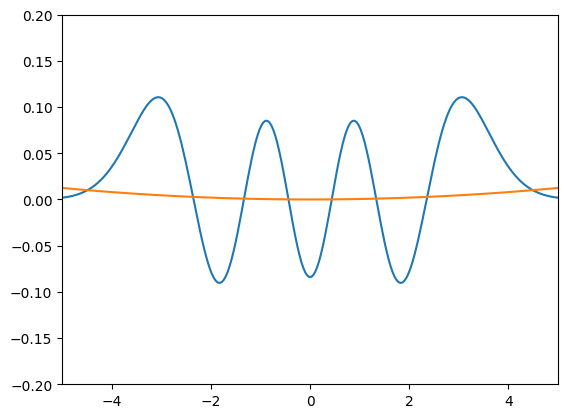

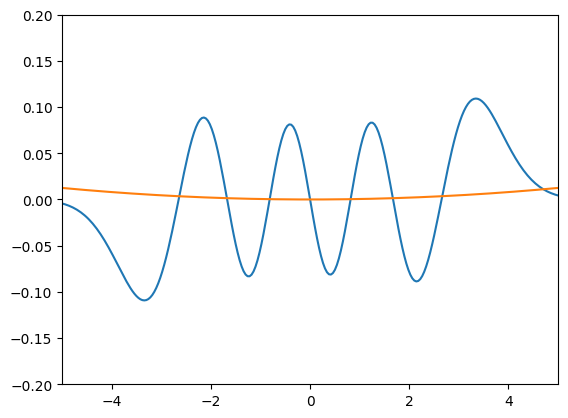

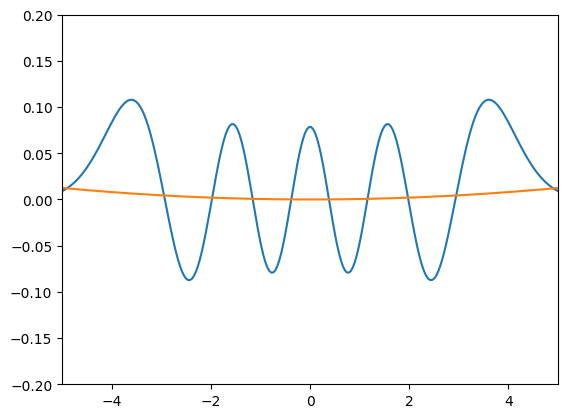

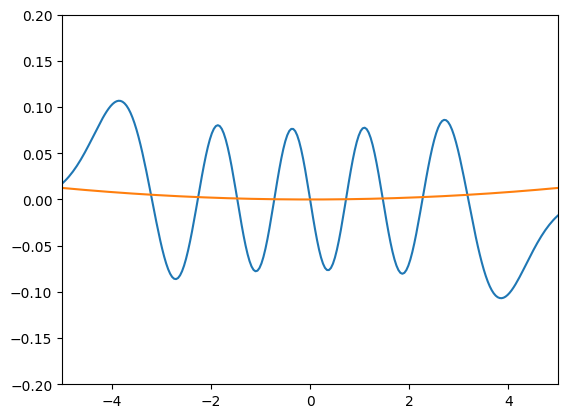

In [120]:
for i in range(k//2):
    if ndims==3:
        plt.imshow(jnp.abs(v.reshape(N,N,N,-1)[N//2,:,:,i]))
        plt.colorbar()
    if ndims==2:
        plt.imshow(jnp.abs(v.reshape(N,N,-1)[:,:,i]))
        plt.colorbar()
    elif ndims==1:
        zz = np.asarray(xyz.reshape(-1))
        plt.plot(zz,v[:,i])
        plt.plot(zz,np.asarray(vmap(vfn)(xyz).reshape(-1))/1000)
        plt.xlim(-5,5)
        plt.ylim(-.2,.2)
    plt.show()

(array([  5.,  34., 166., 481., 814., 814., 481., 166.,  34.,   5.]),
 array([-1.11570495e+01, -8.92563957e+00, -6.69422967e+00, -4.46281978e+00,
        -2.23140989e+00,  4.26325641e-14,  2.23140989e+00,  4.46281978e+00,
         6.69422967e+00,  8.92563957e+00,  1.11570495e+01]),
 <BarContainer object of 10 artists>)

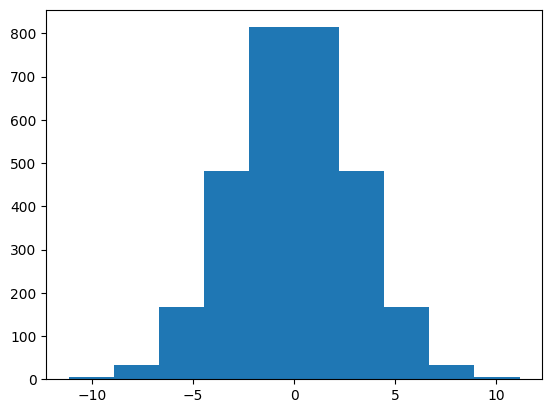

In [83]:
import matplotlib.pyplot as plt
plt.hist(np.asarray(xyz.reshape(-1)))

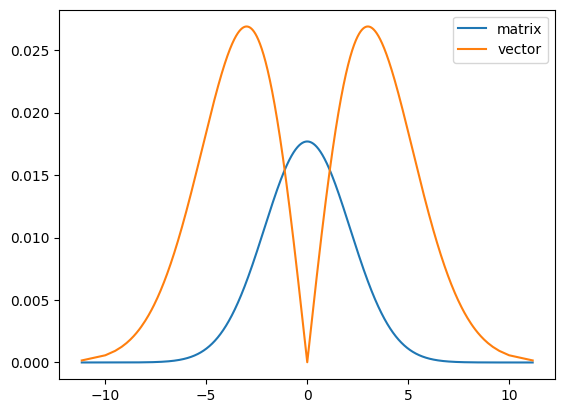

In [77]:
#plt.imshow(vmap(jnp.linalg.norm)(laplacian_factor2).reshape(N,N))
plt.plot(np.asarray(xyz.reshape(-1)),vmap(jnp.linalg.norm)(laplacian_factor2).reshape(N),label='matrix')
plt.plot(np.asarray(xyz.reshape(-1)),vmap(jnp.linalg.norm)(laplacian_factor1).reshape(N),label='vector')
plt.legend()
#plt.colorbar()

In [32]:
xyz

DeviceArray([[-11.15704946],
             [ -9.99164072],
             [ -9.50479814],
             ...,
             [  9.50479814],
             [  9.99164072],
             [ 11.15704946]], dtype=float64)

In [112]:
Es

array([-5.2260380e+00, -2.5537844e+00,  5.1358770e+04,  5.1366480e+04],
      dtype=float32)

In [9]:
%debug

> /home/marc_f/anaconda3/envs/diff2/lib/python3.9/site-packages/jax/_src/lax/lax.py(163)_broadcast_shapes_uncached()
    161   result_shape = _try_broadcast_shapes(shape_list)
    162   if result_shape is None:
--> 163     raise ValueError(f"Incompatible shapes for broadcasting: shapes={list(shapes)}")
    164   return result_shape
    165 

> /home/marc_f/anaconda3/envs/diff2/lib/python3.9/site-packages/jax/_src/numpy/util.py(249)_promote_shapes()
    247         if config.jax_numpy_rank_promotion != "allow":
    248           _rank_promotion_warning_or_error(fun_name, shapes)
--> 249         result_rank = len(lax.broadcast_shapes(*shapes))
    250         return [_broadcast_to(arg, (1,) * (result_rank - len(shp)) + shp)
    251                 for arg, shp in zip(args, shapes)]

    [... skipped 1 hidden frame(s)]

> /home/marc_f/anaconda3/envs/diff2/lib/python3.9/site-packages/jax/_src/numpy/util.py(356)_promote_args()
    354   _check_arraylike(fun_name, *args)
    355   _check_no_